In [1]:
import os
import numpy as np

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="1"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


from functools import partial
import math
from tqdm import tqdm
import time as time

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure 
from torchmetrics.functional import peak_signal_noise_ratio 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.io as sio
from astropy.io import fits

import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg



True
1
0
NVIDIA A100-PCIE-40GB
Using device: cuda


In [2]:
# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 5000, "update_iter": 50, "record_iters": False}


In [3]:
# Save param
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'
# repo_dir = '/Users/tl/Documents/research/repos/proj-convex-UQ/large-scale-UQ'
save_dir = repo_dir + '/debug/sampling-outputs/'


In [4]:
img_name = 'M31'

# Load img
img_path = repo_dir + '/data/imgs/{:s}.fits'.format(img_name)
img_data = fits.open(img_path, memmap=False)

# Loading the image and cast it to float
img = np.copy(img_data[0].data)[0,:,:].astype(np.float64)
# Flipping data
img = np.flipud(img)

# Aliases
x = img
ground_truth = img


INSTRUME                                                                         [astropy.io.fits.card]


In [5]:
# %%
# Load op from X Cai
mask_path = repo_dir + '/data/operators_masks/fourier_mask.mat'
op_mask = sio.loadmat(mask_path)['Ma']

# Matlab's reshape works with 'F'-like ordering
mat_mask = np.reshape(np.sum(op_mask, axis=0), (256,256), order='F').astype(bool)

# %%

torch_img = torch.tensor(np.copy(img), dtype=torch.float64, device=device).reshape((1,1) + img.shape)

# %%
dim = 256
phi = luq.operators.MaskedFourier_torch(
    dim=dim, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)



In [6]:
# Define X Cai noise level
sigma = 0.0024

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Generate noise
rng = np.random.default_rng(seed=0)
n = rng.normal(0, sigma, y[y!=0].shape)
# Add noise
y[y!=0] += n

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=torch.complex128).reshape((1,) + img.shape)
x_init = torch.abs(phi.adj_op(torch_y))


In [7]:
x_init.shape

torch.Size([1, 256, 256])

In [8]:
# Define the likelihood
g = luq.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
g.beta = 1.0 / sigma ** 2


# Define the wavelet dict
wavs_list = ['db8'] # ["db1", "db4"] 
levels = 4
reg_param = 2.e-3
# Define the l1 norm with dict psi
# gamma = torch.max(torch.abs(psi.dir_op(y_torch))) * reg_param
psi = luq.operators.DictionaryWv_torch(wavs_list, levels)

h = luq.operators.L1Norm_torch(1., psi, op_to_coeffs=True)
gamma = h._get_max_abs_coeffs(h.dir_op(torch.clone(x_init))) * reg_param
h.gamma = gamma
h.beta = 1.0

print('gamma: ', gamma)

f = luq.operators.RealProx_torch()


gamma:  0.0073399448136145734


In [9]:
alpha = 1. / (1. + g.beta)

x_hat, diagnostics = luq.optim.FB_torch(
    x_init,
    options=options,
    g=g,
    f=f,
    h=h,
    alpha=alpha,
    tau=1.,
    viewer=None
)


Running Base Forward Backward
[Forward Backward] 0 out of 5000 iterations, tol = 4.08e-01
[Forward Backward] 50 out of 5000 iterations, tol = 9.55e-04
[Forward Backward] converged in 95 iterations


In [10]:

x_hat_np = luq.utils.to_numpy(x_hat)


Dirty
(PSNR: 27.45,
 SNR: 5.01, SSIM: 0.35)
Reconstruction
(PSNR: 45.82,
 SNR: 23.38, SSIM: 0.98)
Residual (x - x^hat)
(PSNR: 22.56,
 SNR: 0.12, SSIM: 0.77)


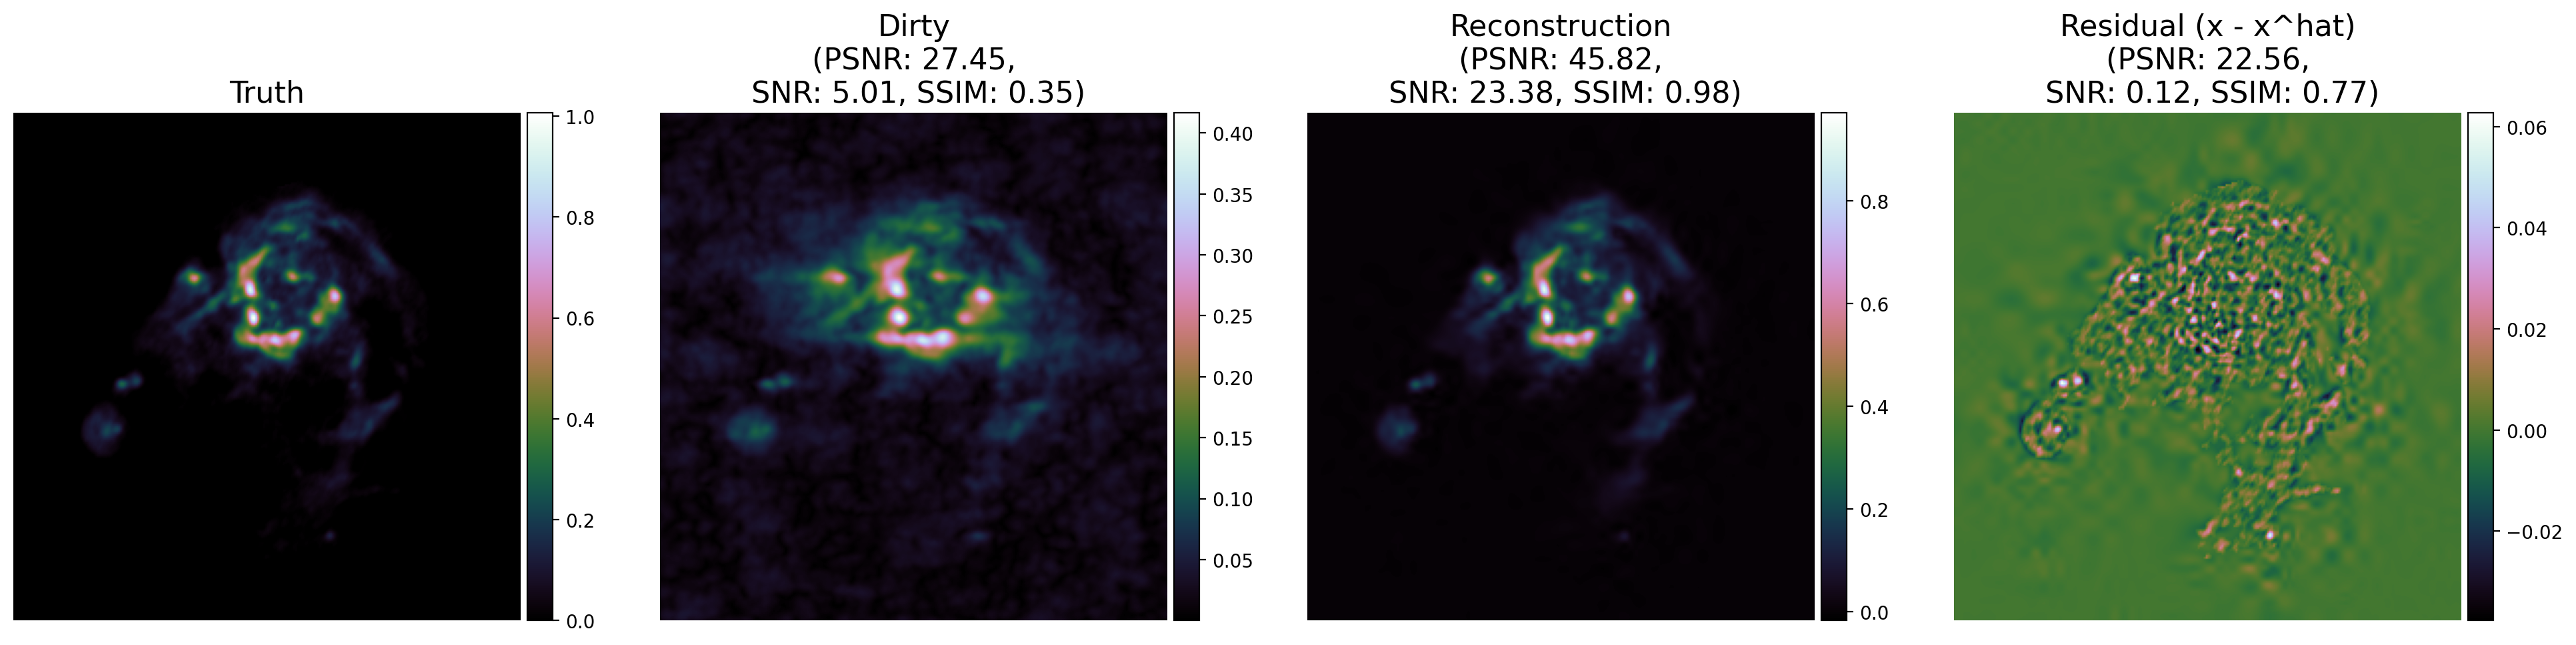

In [15]:
cmap='cubehelix'

# Plot results
images = [
    ground_truth,
    luq.utils.to_numpy(x_init),
    x_hat_np,
    ground_truth - x_hat_np
]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(24,6), dpi=200)
for i in range(4):
    im = axs[i].imshow(images[i], cmap='cubehelix', vmax=np.nanmax(images[i]), vmin=np.nanmin(images[i]))
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i > 0:   
        stats_str = '\n(PSNR: {},\n SNR: {}, SSIM: {})'.format(
            round(psnr(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2),
            round(luq.utils.eval_snr(x, images[i]), 2),
            round(ssim(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2),
            )
        labels[i] += stats_str
        print(labels[i])
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')
# plt.savefig('{:s}{:s}_MAP.pdf'.format(savefig_dir, save_name))
# plt.close()
plt.show()


## UQ

In [40]:
# Compute HPD region


# Instead of using the 

alpha = 0.05

N = x_hat_np.size
tau_alpha = np.sqrt(16*np.log(3/alpha))

# _reg_fun = lambda h, _x: h.fun(h.dir_op(_x))
def _reg_fun(_x, h):
    return h.fun(h.dir_op(_x))
reg_fun = partial(_reg_fun, h=h)

loss_fun_torch = lambda _x : g.fun(_x) +  reg_fun(_x)
loss_fun_np = lambda _x : g.fun(
    luq.utils.to_tensor(_x, dtype=torch.float64)
).item() +  reg_fun(luq.utils.to_tensor(_x, dtype=torch.float64)).item()
# loss_fun = lambda _x : g.fun(_x)

gamma_alpha = loss_fun_torch(x_hat).item() + tau_alpha*np.sqrt(N) + N



In [41]:
print(
    'f(x_map): ', g.fun(x_hat).item(),
    '\ng(x_map): ', reg_fun(x_hat).item(),
    '\ntau_alpha*np.sqrt(N): ', tau_alpha*np.sqrt(N),
    '\nN: ', N,
)
print('tau_alpha: ', tau_alpha)
print('gamma_alpha: ', gamma_alpha.item())



f(x_map):  35053.163154148424 
g(x_map):  2.046833977872795 
tau_alpha*np.sqrt(N):  2072.011448732029 
N:  65536
tau_alpha:  8.093794721609488
gamma_alpha:  102663.22143685832


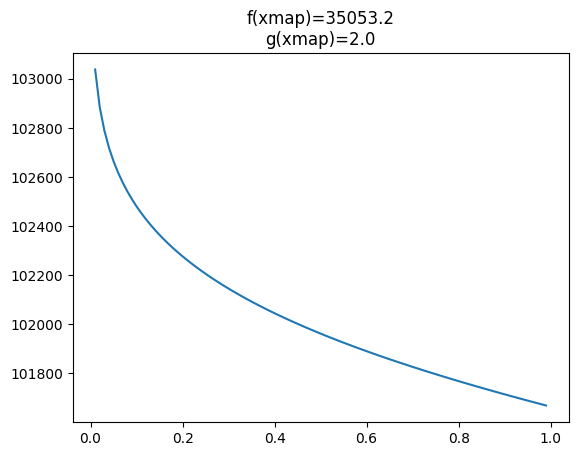

In [33]:

# Plot computed credible region upper bound
likelihood_prior_map_np = g.fun(x_hat).item() + reg_fun(x_hat).item()
upper_bounds = lambda alpha : likelihood_prior_map_np + np.sqrt(16*np.log(3/alpha)) * np.sqrt(N) + N
plot_alphas = np.linspace(0.01, 0.99, 99)

plt.figure()
plt.plot(plot_alphas, upper_bounds(plot_alphas))
plt.title('f(xmap)={:.1f}\ng(xmap)={:.1f}'.format(
    g.fun(x_hat).item(), reg_fun(x_hat).item())
)
# plt.savefig('{:s}{:s}_gamma.pdf'.format(savefig_dir, save_name))
# plt.close()
plt.show()


In [32]:
gamma_alpha

102663.22143685832

In [38]:
# loss_fun_np



array([], shape=(0, 0), dtype=float64)

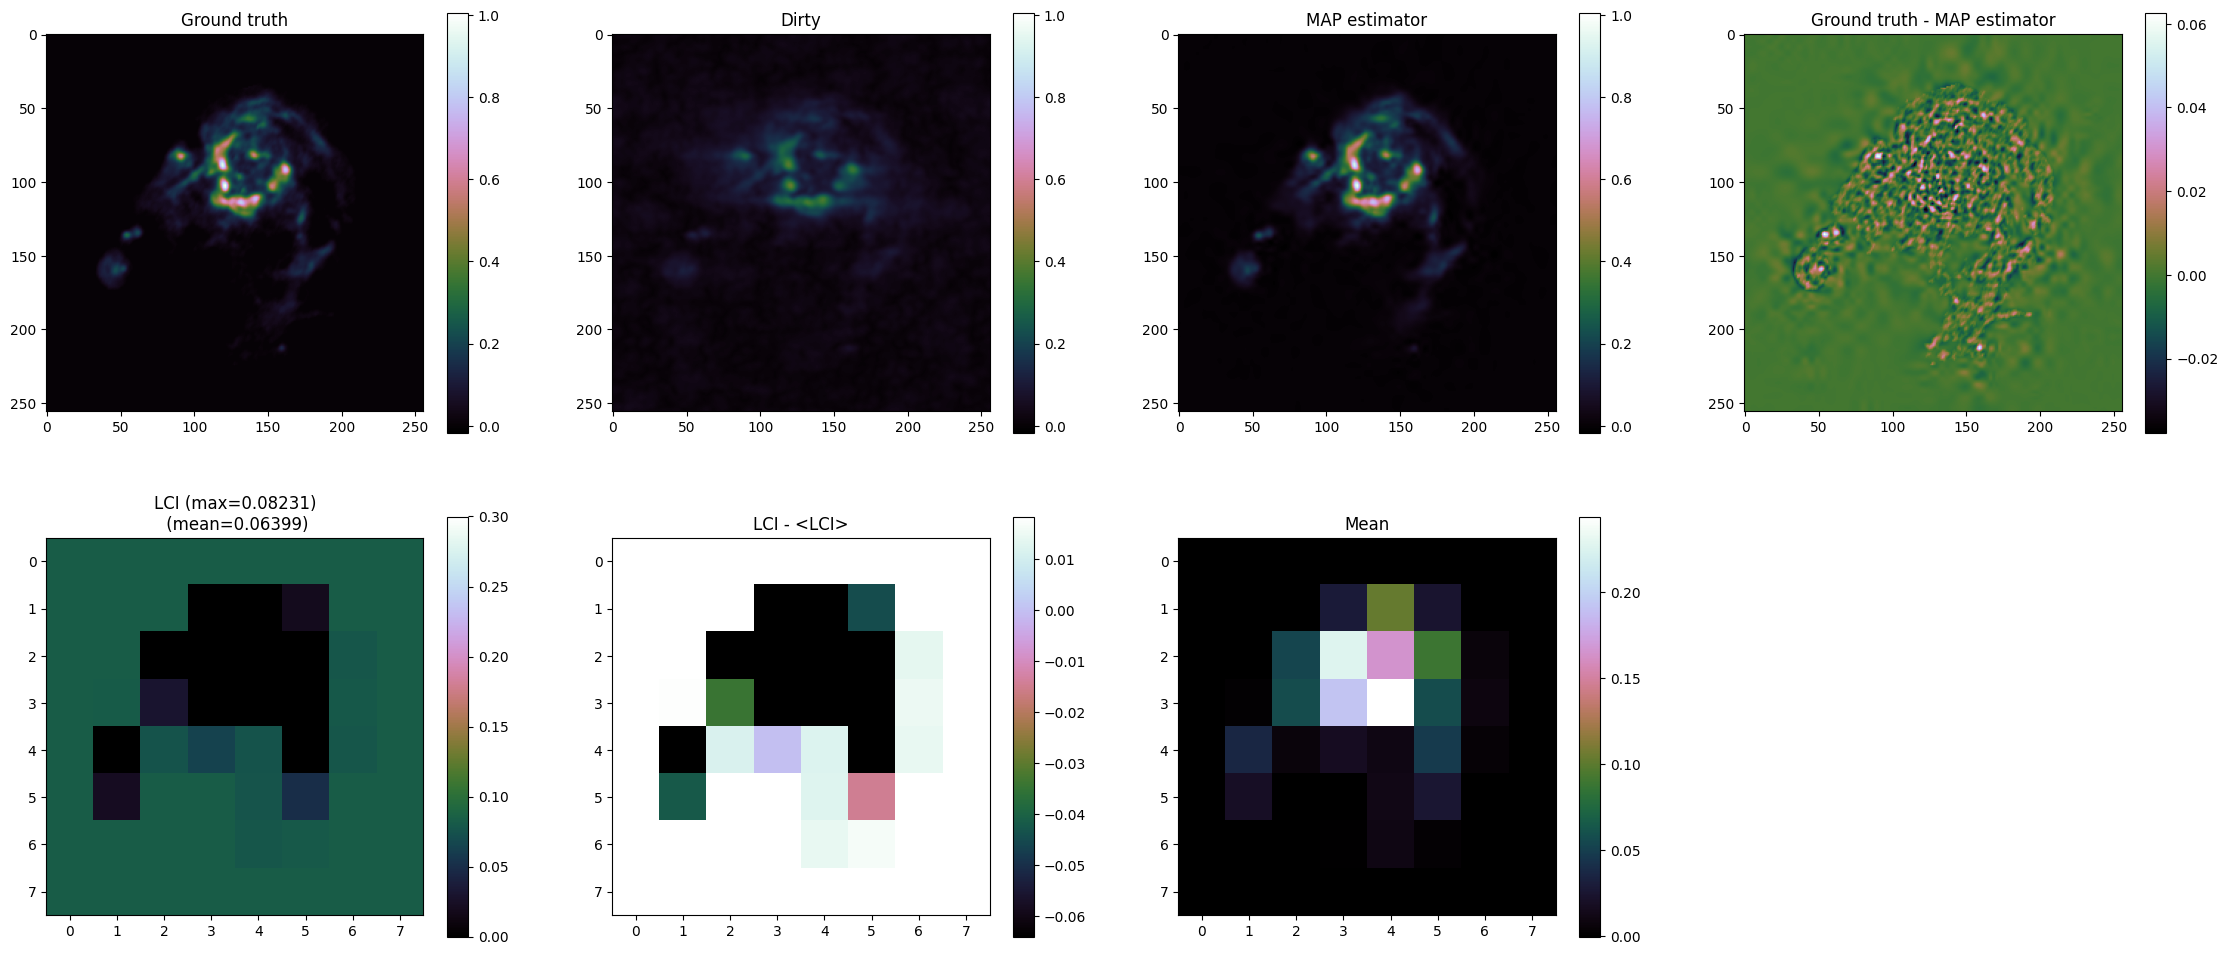

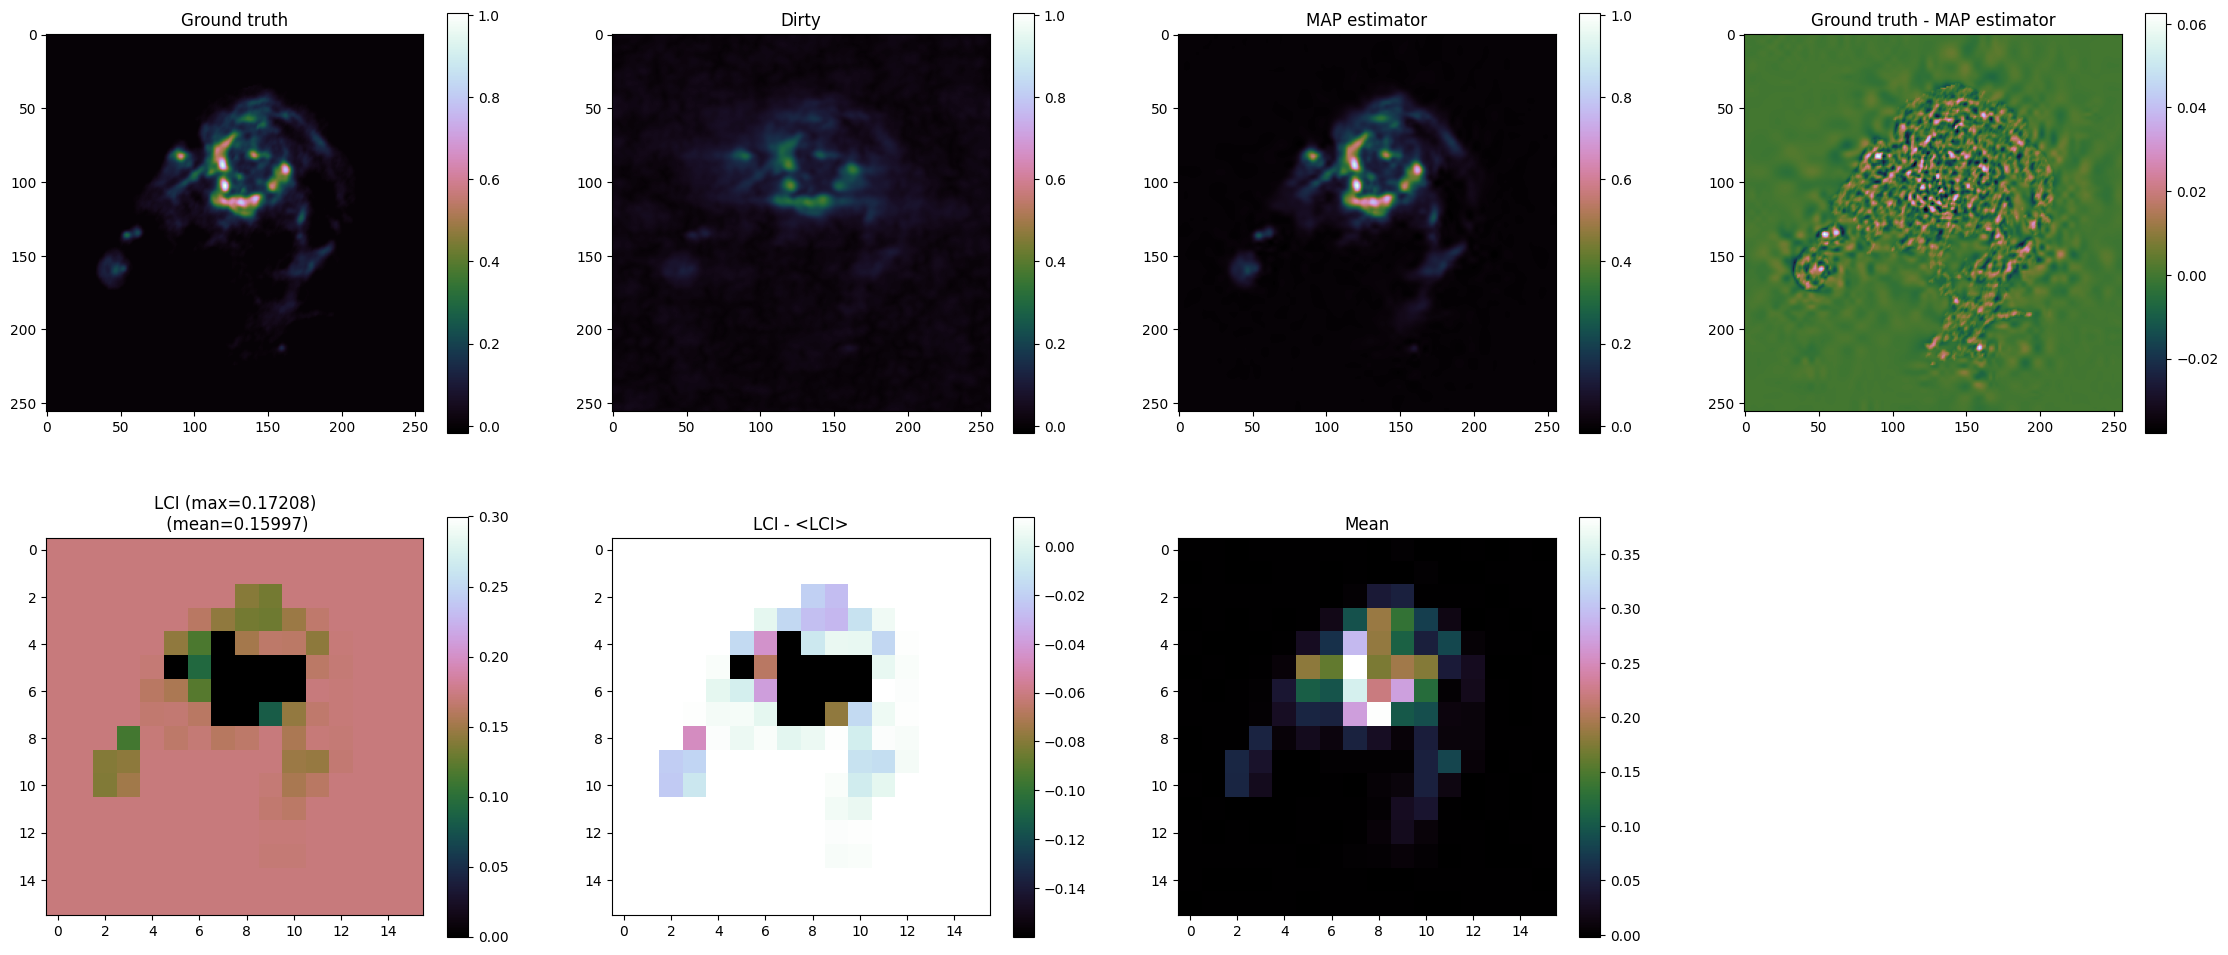

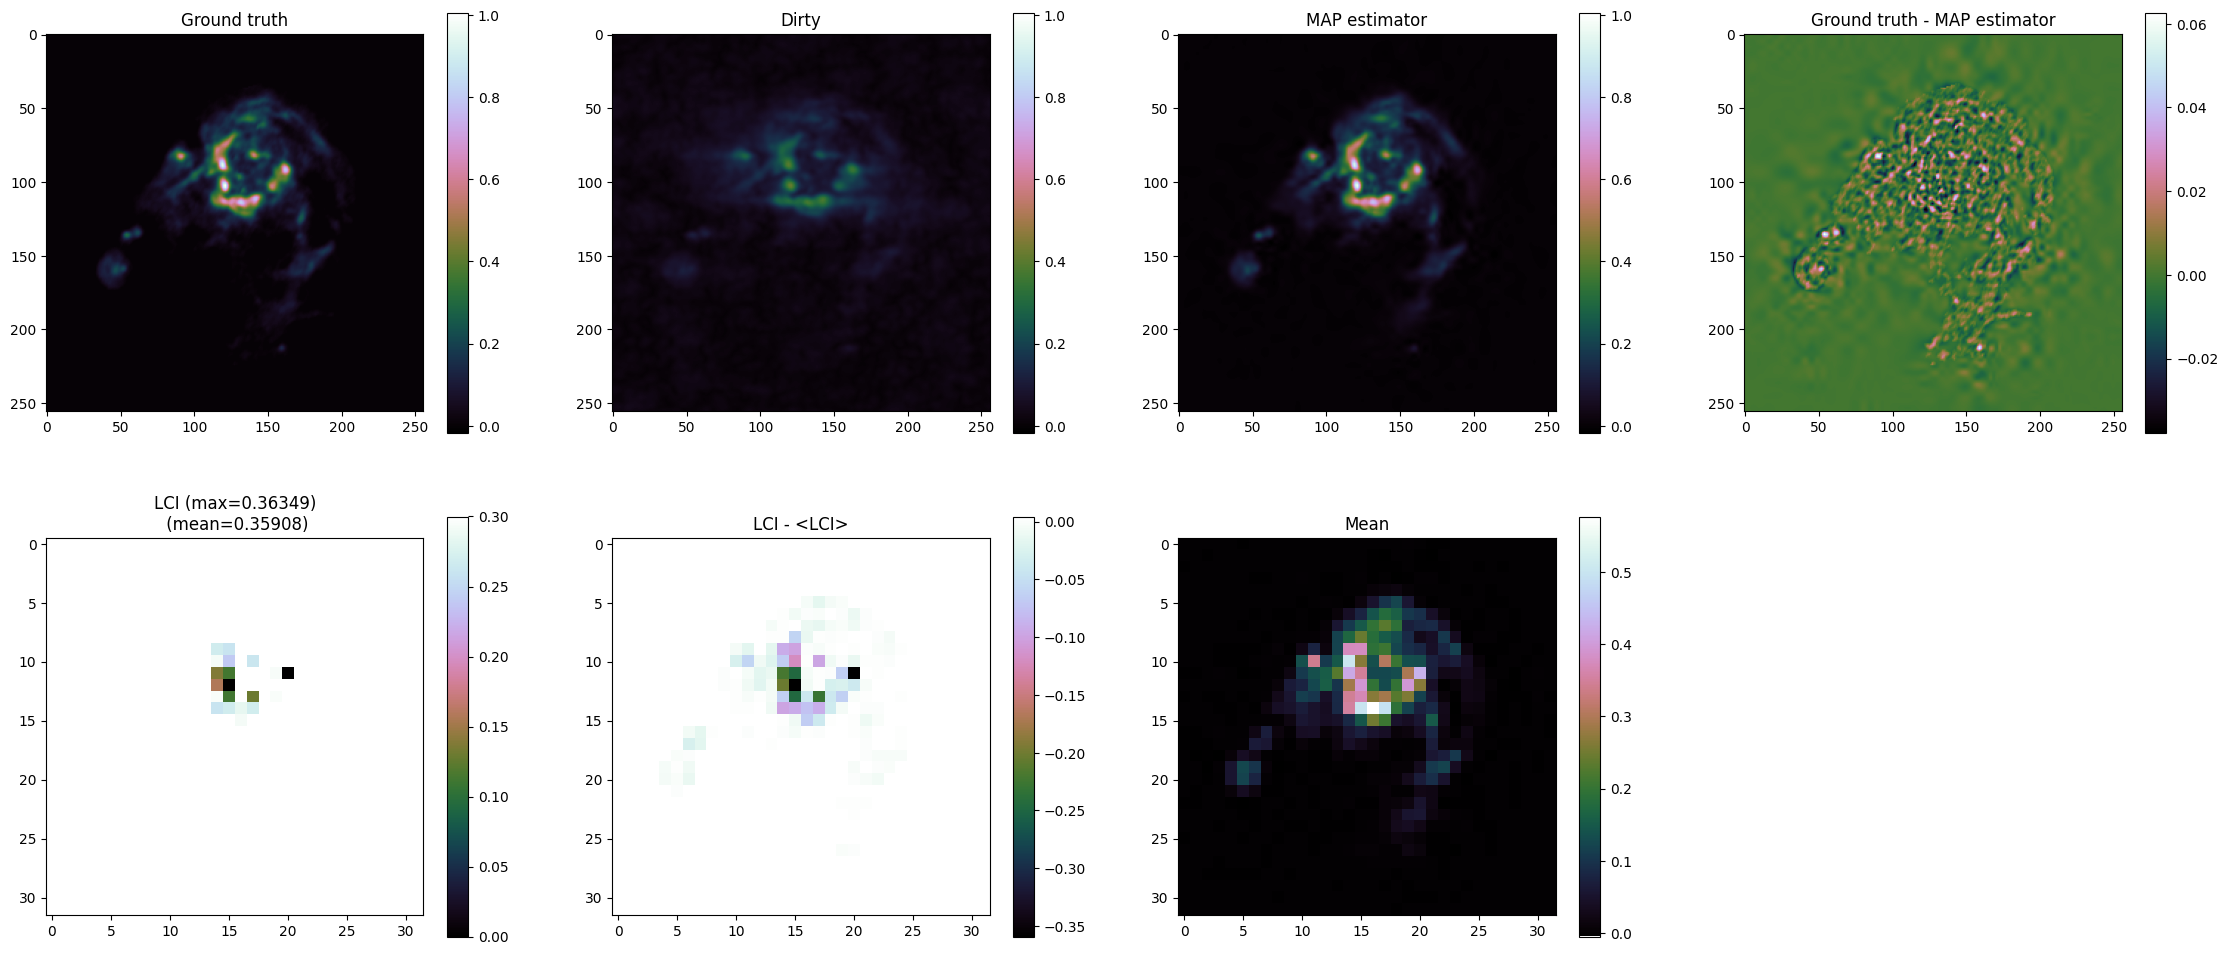

In [44]:
# Compute the LCI
superpix_sizes = [32, 16, 8]
LCI_iters = 200
LCI_tol = 1e-4
LCI_bottom = -10
LCI_top = 10

error_p_arr = []
error_m_arr = []
computing_time = []

x_init_np = luq.utils.to_numpy(x_init)

for superpix_size in superpix_sizes:

    pr_time_1 = time.process_time()
    wall_time_1 = time.time()

    error_p, error_m, mean = luq.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=superpix_size,
    function=loss_fun_np,
    bound=gamma_alpha,
    iters=LCI_iters,
    tol=LCI_tol,
    bottom=LCI_bottom,
    top=LCI_top,
    )
    error_length = error_p - error_m

    pr_time_2 = time.process_time()
    wall_time_2 = time.time()

    error_p_arr.append(np.copy(error_p))
    error_m_arr.append(np.copy(error_m))
    computing_time.append((
        pr_time_2 - pr_time_1, 
        wall_time_2 - wall_time_1
    ))

    vmin = np.min((x, x_init_np, x_hat_np))
    vmax = np.max((x, x_init_np, x_hat_np))
    # err_vmax= 0.6
    cmap='cubehelix'

    plt.figure(figsize=(28,12))
    plt.subplot(241)
    plt.imshow(x, cmap=cmap, vmin=vmin, vmax=vmax);plt.colorbar()
    plt.title('Ground truth')
    plt.subplot(242)
    plt.imshow(x_init_np, cmap=cmap, vmin=vmin, vmax=vmax);plt.colorbar()
    plt.title('Dirty')
    plt.subplot(243)
    plt.imshow(x_hat_np, cmap=cmap, vmin=vmin, vmax=vmax);plt.colorbar()
    plt.title('MAP estimator')
    plt.subplot(244)
    plt.imshow(x - x_hat_np, cmap=cmap);plt.colorbar()
    plt.title('Ground truth - MAP estimator')
    plt.subplot(245)
    plt.imshow(error_length, cmap=cmap, vmin=0, vmax=0.3);plt.colorbar()
    plt.title('LCI (max={:.5f})\n (mean={:.5f})'.format(
        np.max(error_length), np.mean(error_length))
    )
    plt.subplot(246)
    plt.imshow(error_length - np.mean(error_length), cmap=cmap);plt.colorbar()
    plt.title('LCI - <LCI>')
    plt.subplot(247)
    plt.imshow(mean, cmap=cmap);plt.colorbar();plt.title('Mean')
    # plt.savefig(
    #     '{:s}{:s}_pixSize_{:d}.pdf'.format(savefig_dir, save_name, superpix_size)
    # )
    # plt.close()
    plt.show()
